In [4]:
import os
import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision import datasets # CIFAR10, MNIST
import pytorch_lightning as pl

import matplotlib.pyplot as plt

# Dataset

In [141]:
import numpy as np

class XORDataset(Dataset):
    """XOR dataset."""

    def __init__(self, num_samples):
        """
        Args:
            num_samples: number of samples to generate
        """

        self.num_samples = num_samples
        self.X = np.random.randint(0,high=2, size=num_samples*2).reshape((num_samples, 2)).astype(np.float32)
        self.y = np.logical_xor(self.X[:,0], self.X[:,1]).reshape((num_samples,1)).astype(np.float32)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #sample = {'X': self.X[idx], 'y': self.y[idx]}
        sample = (self.X[idx], self.y[idx])

        return sample

In [142]:
X = np.random.randint(0,high=2, size=10*2).reshape((10, 2))
y = np.logical_xor(X[:,0], X[:,1]).astype(np.uint)
print(X)
print(y)
print(X[2])
print(y[2])

[[1 0]
 [0 0]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]]
[1 0 0 1 0 0 0 1 0 1]
[1 1]
0


In [151]:
ds_train = XORDataset(200)
ds_val= XORDataset(50)
ds_test = XORDataset(30)

In [144]:
ds_train[3]


(array([0., 1.], dtype=float32), array([1.], dtype=float32))

# Dataloaders

In [152]:
# Prepare training data loader

# how many samples per batch to load
batch_size=40
train_batch_size = batch_size
valid_batch_size = batch_size
test_batch_size = batch_size

loaders = {
    'train' : torch.utils.data.DataLoader(ds_train,  
                                          batch_size=train_batch_size, 
                                          shuffle=True,
                                          num_workers=1),
    'valid' : torch.utils.data.DataLoader(ds_val, 
                                          batch_size=valid_batch_size, 
                                          shuffle=True,
                                          num_workers=1),
    'test'  : torch.utils.data.DataLoader(ds_test, 
                                          batch_size=test_batch_size , 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f79112e12b0>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7f79112e1940>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f79112e1f40>}

In [146]:
# Let's check the shape of the input/target data
for blob in loaders['train']:
    print(blob)
    data,target = blob
    print('data:', data)
    print('...', type(data))
    print('target:', target)
    print('...', type(target))
    #print(data.shape)
    #print(target.shape)
    break

[tensor([[1., 0.]]), tensor([[1.]])]
data: tensor([[1., 0.]])
... <class 'torch.Tensor'>
target: tensor([[1.]])
... <class 'torch.Tensor'>


# Net model

In [153]:
class XORnet(nn.Module):

    def __init__(self):
        super(XORnet, self).__init__()
        self.linear = nn.Linear(2, 2)
        self.Sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(2, 1)
        self.layers = nn.Sequential(
            self.linear, 
            self.Sigmoid, 
            self.linear2
        )
        # custom weight initialization
        nnLinearLayers = [layer for layer in self.layers if type(layer) == nn.Linear]
        for layer in nnLinearLayers:
            nn.init.normal_(layer.weight)

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [161]:
loss_fn = nn.MSELoss() 

model = XORnet()

# optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.03) 

In [155]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/xor_experiment_1')
dataiter = iter(loaders['train'])
Xs, ys = dataiter.next()
print('Xs:', Xs)
writer.add_graph(model, Xs, verbose=True)


Xs: tensor([[0., 1.],
        [0., 0.],
        [1., 0.],
        [0., 1.],
        [0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.],
        [1., 1.],
        [0., 0.],
        [1., 0.],
        [1., 1.],
        [0., 1.],
        [1., 1.],
        [0., 1.],
        [0., 0.],
        [0., 1.],
        [1., 1.],
        [1., 1.],
        [0., 1.],
        [0., 0.],
        [0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.],
        [1., 1.],
        [0., 0.],
        [0., 1.],
        [0., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [0., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [1., 0.],
        [1., 1.]])
graph(%self.1 : __torch__.___torch_mangle_99.XORnet,
      %x : Float(40, 2, strides=[2, 1], requires_grad=0, device=cpu)):
  %73 : __torch__.torch.nn.modules.container.___torch_mangle_98.Sequential = prim::GetAttr[name="layers"](%self.1)
  %60 : __torch__.torch.nn.modules.l

In [160]:
epoch_training_accuracies=[]
epoch_valid_accuracies=[]

In [162]:
epochs=100

for epoch in range(epochs): 

    train_loss, valid_loss = [], []
    train_epoch_total = 0
    train_epoch_correct = 0
    valid_epoch_total = 0
    valid_epoch_correct = 0
    valid_accuracy = []

    ## training part 
    ##--------------
    model.train()
    for data, target in loaders['train']:

        optimizer.zero_grad()
        ## 1. forward propagation
        output = model(data)
        
        ## 2. loss calculation
        loss = loss_fn(output, target)        
        train_loss.append(loss.item())

        # tensorboard
        writer.add_scalar("Loss/train", loss, epoch)
        
        ## 3. backward propagation
        loss.backward()
        
        ## 4. weight optimization
        optimizer.step()


        #Accuracy
        predicted = (output>0.5).float()
        minibatch_num_corrects = (predicted == target).float().sum()
        minibatch_total = output.shape[0]
        minibatch_accuracy = minibatch_num_corrects.item()/output.shape[0]
        train_epoch_total += minibatch_total
        train_epoch_correct += minibatch_num_corrects.item()

        # print("Epoch {}/{}, Training Loss: {:.3f}, Training Minibatch Accuracy: {:.3f}".format(epoch+1,epochs, loss.item(), minibatch_accuracy))
        
    ## evaluation part
    ## ---------------

    with torch.no_grad():  #gradients should not evaluate
        model.eval()
        for data, target in loaders['valid']:
            output = model(data)
            loss = loss_fn(output, target)
            valid_loss.append(loss.item())
            
            #Accuracy
            output = (output>0.5).float()
            valid_minibatch_num_corrects = (output == target).float().sum()
            valid_minibatch_total = output.shape[0]
            valid_minibatch_accuracy = valid_minibatch_num_corrects.item()/output.shape[0]

            # print("Epoch {}/{}, Valid Loss: {:.3f}, Valid Minibatch Accuracy: {:.3f}".format(epoch+1,epochs, loss.item(), minibatch_accuracy))

            valid_accuracy.append(valid_minibatch_accuracy)
            valid_epoch_total += valid_minibatch_total
            valid_epoch_correct += valid_minibatch_num_corrects.item()

    

    # epoch statistics

    epoch_training_accuracy = 100 * train_epoch_correct / train_epoch_total
    epoch_valid_accuracy = 100 * valid_epoch_correct / valid_epoch_total
    epoch_training_accuracies.append(epoch_training_accuracy )
    epoch_valid_accuracies.append(epoch_valid_accuracy)

    average_validation_accuracy=np.mean(valid_accuracy)
    print("Epoch:", epoch+1, "Training Loss:", np.mean(train_loss),"Valid Loss: ", np.mean(valid_loss), "Valid accuracy: ", np.mean(valid_accuracy))
    print("Training accuracy:", epoch_training_accuracy , ", Valid accuracy:", epoch_valid_accuracy)
    #if average_validation_accuracy == 1:
    #   break

    writer.flush()


Epoch: 1 Training Loss: 1.7903097152709961 Valid Loss:  1.4630687236785889 Valid accuracy:  0.5
Training accuracy: 53.5 , Valid accuracy: 44.0
Epoch: 2 Training Loss: 1.1821526288986206 Valid Loss:  1.0356015861034393 Valid accuracy:  0.4625
Training accuracy: 53.5 , Valid accuracy: 44.0
Epoch: 3 Training Loss: 0.787233316898346 Valid Loss:  0.7024684548377991 Valid accuracy:  0.4625
Training accuracy: 53.5 , Valid accuracy: 44.0
Epoch: 4 Training Loss: 0.522352260351181 Valid Loss:  0.4908582717180252 Valid accuracy:  0.4625
Training accuracy: 53.5 , Valid accuracy: 44.0
Epoch: 5 Training Loss: 0.3745287597179413 Valid Loss:  0.39141610264778137 Valid accuracy:  0.42500000000000004
Training accuracy: 53.5 , Valid accuracy: 44.0
Epoch: 6 Training Loss: 0.30229161977767943 Valid Loss:  0.3018560856580734 Valid accuracy:  0.22499999999999998
Training accuracy: 45.5 , Valid accuracy: 18.0
Epoch: 7 Training Loss: 0.2804424226284027 Valid Loss:  0.2930397689342499 Valid accuracy:  0.55
Trai

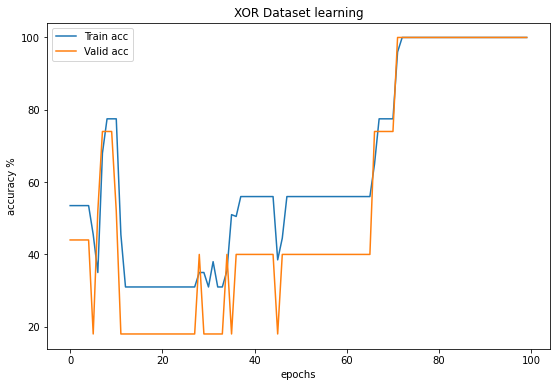

In [163]:
fig, axs = plt.subplots(1, 1, figsize=(9, 6))  
axs.plot(epoch_training_accuracies, label='Train acc')
axs.plot(epoch_valid_accuracies, label='Valid acc')
axs.set_title('XOR Dataset learning')
axs.set_xlabel('epochs')
axs.set_ylabel('accuracy %')
plt.legend()
plt.show()